# Text vectorisation: Turning Text into Features

# Part 1: N-grams and TF-IDF models 

More advanced forms of text analysis require that text documents are converted into numerical values or features. In this  section we will examine:

* different methods for representing a collection of texts as numbers
* the decisions we need to make when generating a particular representation as well as the kinds of insights each numerical representation can give us.

We will use tools from the Python libraries `scikit-learn` and `gensim` to perform some popular text vectorisation methods:
* Re-cap of N-grams (unigram and bi-gram) term friquency
* TF-IDF (Term Frequency–Inverse Document Frequency)
* Word embedding—Word2Vec

In [12]:
# Import libraries

! pip install gensim
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Defaulting to user installation because normal site-packages is not writeable


## Turning text into n-grams features 
### Unigrams

Compute the friquency of word occurance using count vectoriser in `scikit-learn`  

### Toy example

In [5]:
# Text corpus

# Load the parsed news dataset 
corpus = pd.read_csv('sample_news_large_phrased.csv', index_col='index')

In [13]:
corpus.head(1)

,query,title,text,published,site,tokens
index,,,,,,
0,Hong Kong,Horrifying view of fires from space,"Video Image Satellite images show insane view of NSW fires from space Satellite images show the huge amount of smoke billowing from a number of bushfires across NSW.\nThe NSW fires, as seen from s...",2019-11-08T23:51:00.000+02:00,news.com.au,video|*|image|*|satellite|*|image|*|insane|*|view|*|nsw|*|fire|*|space|*|satellite|*|image|*|huge|*|smoke|*|billow|*|number|*|bushfire|*|nsw|*|nsw|*|fire|*|space|*|source|*|twitter|*|startling|*|s...


In [15]:
corpus[corpus['query']=='brexit']

,query,title,text,published,site,tokens
index,,,,,,
125,brexit,PM asks EU for Brexit delay but remains committed to Halloween deadline | Politics News | Sky News,"Boris Johnson has asked the EU for a three-month delay to Brexit, which would extend the Article 50 negotiating period to 31 January 2020.\nThe request to European Council President Donald Tusk wa...",2019-10-19T23:14:00.000+03:00,sky.com,boris_johnson|*|ask|*|eu|*|month|*|delay|*|brexit|*|extend|*|article|*|negotiating|*|period|*|january|*|request|*|european|*|council|*|president_donald|*|tusk|*|unsigned|*|letter|*|late|*|saturday...
126,brexit,Brexit: PM sends letter to Brussels seeking further delay - BBC News,"Media playback is unsupported on your device Media caption Boris Johnson: ""I will not negotiate a delay with the EU"" Boris Johnson has sent a request to the EU for a delay to Brexit - but without ...",2019-10-19T03:00:00.000+03:00,bbc.co.uk,medium|*|playback|*|unsupported|*|-pron-|*|device|*|medium|*|caption|*|boris_johnson|*|-pron-|*|negotiate|*|delay|*|eu|*|boris_johnson|*|send|*|request|*|eu|*|delay|*|brexit|*|-pron-|*|signature|*...
127,brexit,Nearly half of UK think Boris Johnson is lying about protecting NHS from Trump trade deal | The Independent,Nearly half of UK think Boris Johnson is lying about protecting NHS from Trump trade deal The Independent 28/10/2019 Peter Stubley © Provided by Independent Digital News & Media Limited Nearly hal...,2019-10-28T02:27:00.000+02:00,independent.co.uk,nearly|*|half|*|uk|*|think|*|boris_johnson|*|lie|*|protect|*|nhs|*|trump|*|trade_deal|*|independent|*|peter|*|stubley|*|provide|*|independent|*|digital|*|news|*|media|*|limited|*|nearly|*|half|*|b...
128,brexit,Biggest UK problem is its PARLIAMENT that thinks its ABOVE the people' Finnish MEP blasts | UK | News | Express.co.uk,Finnish MEP Laura Huhtasaari joined other non-UK European Parliament members on Sky News to debate the UK's exit from the European Union and Boris Johnson 's new deal. She told presenter Adam Boul...,2019-10-17T14:22:00.000+03:00,express.co.uk,finnish|*|mep|*|laura|*|huhtasaari|*|join|*|non|*|uk|*|european|*|parliament|*|member|*|sky_news|*|debate|*|uk|*|exit|*|european_union|*|boris_johnson|*|new|*|deal|*|-pron-|*|tell|*|presenter|*|ad...
129,brexit,"People’s Vote march: from every corner of the land they came, to join a very British rebellion in the rain | Politics | The Guardian","A s the news of the success of the Letwin amendment filtered out to the hundreds of thousands who had once again marched to Parliament Square to demand a People’s Vote on the Brexit deal, there wa...",2019-10-19T20:20:00.000+03:00,theguardian.com,s|*|news|*|success|*|letwin|*|amendment|*|filter|*|thousand|*|march|*|parliament|*|square|*|demand|*|people|*|vote|*|brexit_deal|*|reassuringly|*|british|*|reaction|*|widespread|*|applause|*|rain|...
130,brexit,General election: Boris Johnson to ask MPs to back 12 December poll | The Independent,"Boris Johnson has announced he is seeking a 12 December general election .And the prime minister said that in return for backing his plan on Monday, he will offer MPs more time to debate and scrut...",2019-10-24T20:18:00.000+03:00,independent.co.uk,boris_johnson|*|announce|*|-pron-|*|seek|*|december|*|general_election|*|prime_minister|*|return|*|-pron-|*|plan|*|monday|*|-pron-|*|offer|*|mps|*|time|*|debate|*|scrutinise|*|-pron-|*|brexit_deal...
131,brexit,CCTV shows Essex lorry minutes before 39 people found dead inside | UK News | Sky News,Private ambulances under police escort are transporting some of the 39 bodies found in a lorry container in Essex to a hospital for post-mortems.\nAt least 11 of the victims discovered at an indus...,2019-10-23T16:53:00.000+03:00,sky.com,private|*|ambulance|*|police|*|escort|*|transport|*|body|*|find|*|lorry|*|container|*|essex|*|hospital|*|post|*|mortem|*|victim|*|discover|*|industrial_estate|*|week|*|police|*|believe|*|chinese|*...
132,brexit,Brexit news: Gina Miller unveils new Remainer 

In [16]:
# Subset news stories about brexit
corpus_brexit = corpus[corpus['query']=='brexit']

corpus_toy=corpus_brexit.iloc[[7,22], [1]]

# Set the maximum width of columns
pd.options.display.max_colwidth = 200

corpus_toy.head(5)

,title
index,
132,Brexit news: Gina Miller unveils new Remainer plot to block Brexit in general election | UK | News | Express.co.uk
147,Brexit news: Labour pledge to continue ‘freedom of movement’ infuriates Leavers | UK | News | Express.co.uk


In [17]:
# Use CountVectorizer to tokenize a collection of text documents and convert 
# it into a matrix of token counts

# Create an instance of the CountVectorizer class
vectorizer = CountVectorizer()

# Learn the vocabulary from the corpus using the toy corpus
vectorizer.fit(corpus_toy['title'])

# Transform documents to document-term matrix
vector = vectorizer.transform(corpus_toy['title'])

# Print the tokens as a dictionary with tokens (keys) and 
# integer feature indices (values) using the vocabulary_ attribute
print(vectorizer.vocabulary_)

{'brexit': 1, 'news': 16, 'gina': 8, 'miller': 13, 'unveils': 23, 'new': 15, 'remainer': 20, 'plot': 19, 'to': 21, 'block': 0, 'in': 9, 'general': 7, 'election': 4, 'uk': 22, 'express': 5, 'co': 2, 'labour': 11, 'pledge': 18, 'continue': 3, 'freedom': 6, 'of': 17, 'movement': 14, 'infuriates': 10, 'leavers': 12}


Note that punctuation and single letter's words are removed. We will use below the prerpocessed tokens you have already preprocessed.

In [23]:
# Access the feature index of a token
vectorizer.vocabulary_.get('block')

0

The numbers assigned to each token (e.g., "brexit") are indices. For clarity, indices are sorted in the cell bellow.

In [22]:
# Print the document-term matrix of rows (documents) and 
# columns (count for the number of times a token appeared in the document) 
print(vector.toarray())

[[1 2 1 0 1 1 0 1 1 1 0 0 0 1 0 1 2 0 0 1 1 1 2 1]
 [0 1 1 1 0 1 1 0 0 0 1 1 1 0 1 0 2 1 1 0 0 1 2 0]]


`vector.toarray()` returns a matrix where the rows indicate the number of documents (two in our case) and the columns indicate the size of the vocabulary of the entire corpus (all documents).

Each document is encoded as a vector with a length indicating the size of the vocabulary of the entire corpus and an integer count for the number of times each token appeared in the document.

In [24]:
# Sort the dictionary of terms (keys) and indices (values) in the feature matrix by values in ascending order
print(dict(sorted(vectorizer.vocabulary_.items(), key=lambda item: item[1])))

# Print the document-term matrix
print(vector.toarray())

{'block': 0, 'brexit': 1, 'co': 2, 'continue': 3, 'election': 4, 'express': 5, 'freedom': 6, 'general': 7, 'gina': 8, 'in': 9, 'infuriates': 10, 'labour': 11, 'leavers': 12, 'miller': 13, 'movement': 14, 'new': 15, 'news': 16, 'of': 17, 'pledge': 18, 'plot': 19, 'remainer': 20, 'to': 21, 'uk': 22, 'unveils': 23}
[[1 2 1 0 1 1 0 1 1 1 0 0 0 1 0 1 2 0 0 1 1 1 2 1]
 [0 1 1 1 0 1 1 0 0 0 1 1 1 0 1 0 2 1 1 0 0 1 2 0]]


The output consists of 24 unigram features. The 1st token `brexit` has appeared twice in the first title and once in the second title.

In [9]:
# Find (1) the most friquent token in a document, (2) the number of times it appears in that document 
# and (3) the document in which it appears
maximum = vector.toarray().max()
index_of_maximum = np.where(vector.toarray() == maximum)

print("max:", maximum)
print("index:", index_of_maximum)

max: 2
index: (array([0, 0, 0, 1, 1]), array([ 1, 16, 22, 16, 22]))


In [10]:
# Sort the vector of integer count in ascending order
np.sort(vector.toarray())

array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
        2, 2],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        2, 2]])

### Example using the entire data set of News Tokens

In [25]:
corpus['text'].head()

index
0    Video Image Satellite images show insane view of NSW fires from space Satellite images show the huge amount of smoke billowing from a number of bushfires across NSW.\nThe NSW fires, as seen from s...
1    \n Chief Executive addresses the press after citywide chaos and transport disruptions \n Earlier, police shoot protester leaving him in intensive care, while separately, a man is set on fire durin...
2    Hong Kong (CNN) China has announced a curfew on online gaming for minors among new measures aimed at curbing video game addiction.\nThe official government guidelines will be applied to all online...
3    Washington (CNN) President Donald Trump was relentlessly dishonest last week about the scandal over his dealings with Ukraine, making false claims about just about every component of the story.\nT...
4    (CNN) — What is bread? You likely don't have to think for long, and whether you're hungry for a slice of sourdough or craving some tortillas, what you imagine says a lot

In [26]:
# Convert a collection of text documents to a matrix of token counts

vectorizer_corpus = CountVectorizer()

#  Learn the vocabulary from the corpus and tokenise
vectorizer_corpus.fit(corpus['text'])

# Transform documents to document-term matrix
vector_corpus = vectorizer_corpus.transform(corpus['text'])

# Print the tokens as a dictionary with tokens (keys) and integer feature indices (values) using the vocabulary_ attribute
print(dict(sorted(vectorizer_corpus.vocabulary_.items(), key=lambda item: item[1])))

{'00': 0, '000': 1, '0002': 2, '000th': 3, '0010': 4, '0044': 5, '01': 6, '013': 7, '02': 8, '020': 9, '03': 10, '04': 11, '04c76inq0a': 12, '05': 13, '056': 14, '05am': 15, '06': 16, '07': 17, '08': 18, '0800': 19, '09': 20, '0944': 21, '0iiwtfu5gq': 22, '0s': 23, '10': 24, '100': 25, '1000': 26, '100m': 27, '101': 28, '102': 29, '103': 30, '104': 31, '105': 32, '106': 33, '106619': 34, '107': 35, '108': 36, '109': 37, '109554': 38, '10am': 39, '10k': 40, '10pm': 41, '10th': 42, '11': 43, '110': 44, '110541': 45, '111': 46, '112': 47, '113': 48, '114': 49, '115': 50, '116': 51, '117': 52, '117513': 53, '118': 54, '1187098428737753091': 55, '119': 56, '11th': 57, '12': 58, '120': 59, '1200': 60, '121': 61, '121647': 62, '122': 63, '123': 64, '124': 65, '125': 66, '126': 67, '127': 68, '128': 69, '129': 70, '12bn': 71, '12m': 72, '12th': 73, '13': 74, '130': 75, '131': 76, '132': 77, '132m': 78, '133': 79, '134': 80, '135': 81, '136': 82, '137': 83, '138': 84, '139': 85, '13am': 86, '14

In [13]:
# Print the document-term matrix
print(vector_corpus.toarray())

[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [14]:
# Dimensions of vector_corpus.toarray(), i.e., number of rows and columns
vector_corpus.toarray().shape

(175, 14322)

## Exercise 1

Using the entire corpus, find (1) the most friquent token in a document, (2) the number of times it appears in that document and (3) the document in which it appears.

In [15]:
# Please write below the code for Exercise 1

maximum = vector_corpus.toarray().max()
index_of_maximum = np.where(vector_corpus.toarray() == maximum)

print("max:", maximum)
print("token index:", index_of_maximum)

max: 573
token index: (array([3]), array([12823]))


The the most frequent token is in document 3 and indexed 12823. 

In [16]:
# Find the token indexed 12823 by getting a key in a dictionary by its value 
# The value in the "vectorizer_corpus.vocabulary_" is the token index

dict((v,k) for k,v in vectorizer_corpus.vocabulary_.items())[12823]

'the'

In [17]:
# To double check, get value by key

vectorizer_corpus.vocabulary_.get('the')

12823

### Bi-grams (combination of two tokens)
In the unigram transformation, each token is a feature. For example, `general` and `election` are two separate features. The bi-gram transformation relaxes this contrain by pairing each word to previous and subsequent words.  

In [18]:
# Extracting unigrams and bigrams
    # ngram_range of (1, 1) extracts unigrams
    # ngram_range of (1, 2) extracts unigrams and bigrams
    # ngram_range of (1, 2) extracts bigrams

# Create an instance of the CountVectorizer class set bigram extraction   
vectorizer = CountVectorizer(ngram_range=(2,2))

# Learn the vocabulary from the corpus and tokenise
vectorizer.fit(corpus_toy['title'])

# Transform documents to document-term matrix
vector = vectorizer.transform(corpus_toy['title'])

# Print the tokens as a dictionary with tokens (keys) and integer feature indices (values) using vocabulary_
print(dict(sorted(vectorizer.vocabulary_.items(), key=lambda item: item[1])))

# Print the document-term matrix
print(vector.toarray())

{'block brexit': 0, 'brexit in': 1, 'brexit news': 2, 'co uk': 3, 'continue freedom': 4, 'election uk': 5, 'express co': 6, 'freedom of': 7, 'general election': 8, 'gina miller': 9, 'in general': 10, 'infuriates leavers': 11, 'labour pledge': 12, 'leavers uk': 13, 'miller unveils': 14, 'movement infuriates': 15, 'new remainer': 16, 'news express': 17, 'news gina': 18, 'news labour': 19, 'of movement': 20, 'pledge to': 21, 'plot to': 22, 'remainer plot': 23, 'to block': 24, 'to continue': 25, 'uk news': 26, 'unveils new': 27}
[[1 1 1 1 0 1 1 0 1 1 1 0 0 0 1 0 1 1 1 0 0 0 1 1 1 0 1 1]
 [0 0 1 1 1 0 1 1 0 0 0 1 1 1 0 1 0 1 0 1 1 1 0 0 0 1 1 0]]


The output consists of 28 bigram-based features. The count is either 1 or 0 for each of our bigram.     

##  Term frequency–inverse document frequency (TF-IDF)

TF-IDF vectorisation weights down tokens that are present across many documents in the corpus (in particular, words like "of" and "the" if stop words are not removed) and are therefore less informative than tokens that are present in specific documents in the corpus. 

### Toy example

In [19]:
# Convert a collection of raw documents to a matrix of TF-IDF features
vectorizer = TfidfVectorizer(norm=None)

# Learn the vocabulary from the corpus and tokenise
matrix = vectorizer.fit_transform(corpus_toy['title'])

# Print the tokens as a dictionary with tokens (keys) and integer feature indices (values) using vocabulary_
print(dict(sorted(vectorizer.vocabulary_.items(), key=lambda item: item[1])))

# Print the IDF scores 
print(vectorizer.idf_)

{'block': 0, 'brexit': 1, 'co': 2, 'continue': 3, 'election': 4, 'express': 5, 'freedom': 6, 'general': 7, 'gina': 8, 'in': 9, 'infuriates': 10, 'labour': 11, 'leavers': 12, 'miller': 13, 'movement': 14, 'new': 15, 'news': 16, 'of': 17, 'pledge': 18, 'plot': 19, 'remainer': 20, 'to': 21, 'uk': 22, 'unveils': 23}
[1.40546511 1.         1.         1.40546511 1.40546511 1.
 1.40546511 1.40546511 1.40546511 1.40546511 1.40546511 1.40546511
 1.40546511 1.40546511 1.40546511 1.40546511 1.         1.40546511
 1.40546511 1.40546511 1.40546511 1.         1.         1.40546511]


#### The above computes the `IDF` part. Let's get the `TF` (term frequency) as before 

In [20]:
# We use the CountVectorizer function we used above to count n-grams
vectorizer = CountVectorizer()
vectorizer.fit(corpus_toy['title'])
vector = vectorizer.transform(corpus_toy['title'])
print(vector.toarray())

[[1 2 1 0 1 1 0 1 1 1 0 0 0 1 0 1 2 0 0 1 1 1 2 1]
 [0 1 1 1 0 1 1 0 0 0 1 1 1 0 1 0 2 1 1 0 0 1 2 0]]


#### Below we get the TF-IDF for our toy corpus

In [21]:
# Convert the TF-IDF matrix into a DataFrame   
tf_idf_df = pd.DataFrame(matrix.toarray(), columns=vectorizer.get_feature_names())
tf_idf_df

,block,brexit,co,continue,election,express,freedom,general,gina,in,...,movement,new,news,of,pledge,plot,remainer,to,uk,unveils
0,1.405465,2.0,1.0,0.000000,1.405465,1.0,0.000000,1.405465,1.405465,1.405465,...,0.000000,1.405465,2.0,0.000000,0.000000,1.405465,1.405465,1.0,2.0,1.405465
1,0.000000,1.0,1.0,1.405465,0.000000,1.0,1.405465,0.000000,0.000000,0.000000,...,1.405465,0.000000,2.0,1.405465,1.405465,0.000000,0.000000,1.0,2.0,0.000000


### How is TF-IDF computed by `scikit-learn`?  


TF-IDF(t,d) = TF * IDF

What is the TF-IDF of the term 'brexit' which is term 1 in document 0 so TF-IDF(1,0)

TF = 2

IDF = log(N + 1 / n + 1) + 1 where N is the total number of documents and n is the number of documents in which the term appears; constant “1” is added to the numerator and denominator to prevent zero divisions (see [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)). 


In [22]:
import math as m
# the term "brexit" is present in two of two documents
IDF = m.log((2+1)/(2+1))+1 
IDF

1.0

So TF-IDF for term 1 (brexit) in document 0 is **TF-IDF (1,0) = TF * TDF = 2 * 1 = 2**

#### Let's try another example, the fourth term ('election') in document 0

TF-IDF(4.0) = TF * IDF

TF = 1

In [23]:
# the term "election" is present in one of two documents
IDF = m.log((2+1)/(1+1))+1
IDF

1.4054651081081644

So TF-IDF for term 4 ('election') in document 0 is **TF-IDF (4,0) = TF * TDF = 1 * 1.405 = 1.405**

#### The above TF-IDF matrix is not normalised. Typically, it is recommended that the TF-IDF weights are normalised meaning that the weights in the matrix will range between 0 and 1. Below is the normalisation code (L2 normalisation is default in the TfidfVectorizer function but we indicate it below for clarity)

In [24]:
# Convert a collection of raw documents to a matrix of TF-IDF features
vectorizer = TfidfVectorizer(norm ='l2')

# Learn the vocabulary from the corpus and create a document-term matrix
matrix = vectorizer.fit_transform(corpus_toy['title'])

# Convert the TF-IDF matrix into a DataFrame
pd.DataFrame(matrix.toarray(), columns=vectorizer.get_feature_names())

,block,brexit,co,continue,election,express,freedom,general,gina,in,...,movement,new,news,of,pledge,plot,remainer,to,uk,unveils
0,0.238409,0.339259,0.169630,0.000000,0.238409,0.169630,0.000000,0.238409,0.238409,0.238409,...,0.000000,0.238409,0.339259,0.000000,0.000000,0.238409,0.238409,0.169630,0.339259,0.238409
1,0.000000,0.189652,0.189652,0.266549,0.000000,0.189652,0.266549,0.000000,0.000000,0.000000,...,0.266549,0.000000,0.379303,0.266549,0.266549,0.000000,0.000000,0.189652,0.379303,0.000000


### TF-IDF vectorisation of the 'raw' news sub-corpus related to Brexit

In [25]:
# Convert our corpus of raw documents to a matrix of TF-IDF features
vectorizer = TfidfVectorizer()

# Learn the vocabulary from the corpus and create a document-term matrix
matrix = vectorizer.fit_transform(corpus_brexit['text'])

# Print the tokens as a dictionary with tokens (keys) and integer feature indices (values) using vocabulary_
print(dict(sorted(vectorizer.vocabulary_.items(), key=lambda item: item[1])))

{'00': 0, '000': 1, '0010': 2, '0044': 3, '01': 4, '020': 5, '05': 6, '056': 7, '05am': 8, '06': 9, '07': 10, '08': 11, '0800': 12, '0944': 13, '10': 14, '100': 15, '10am': 16, '10pm': 17, '11': 18, '115': 19, '11th': 20, '12': 21, '12bn': 22, '13': 23, '13am': 24, '14': 25, '15': 26, '150': 27, '158': 28, '16': 29, '166': 30, '17': 31, '18': 32, '19': 33, '190': 34, '1939': 35, '1940': 36, '1956': 37, '1966': 38, '1969': 39, '1978': 40, '1979': 41, '1982': 42, '1983': 43, '1984': 44, '1985': 45, '1991': 46, '1993': 47, '1995': 48, '1998': 49, '20': 50, '2000': 51, '2003': 52, '2006': 53, '2009': 54, '2010': 55, '2012': 56, '2013': 57, '2016': 58, '2017': 59, '2019': 60, '2020': 61, '2021': 62, '2027': 63, '207': 64, '21': 65, '218': 66, '22': 67, '23': 68, '24': 69, '25': 70, '25c': 71, '268': 72, '27': 73, '277': 74, '28': 75, '29': 76, '299': 77, '2am': 78, '30': 79, '306': 80, '308': 81, '30am': 82, '30pm': 83, '31': 84, '322': 85, '329': 86, '33': 87, '3490': 88, '35': 89, '37': 9

In [26]:
# Print the IDF scores
print(vectorizer.idf_)

[2.64865863 3.15948425 3.56494936 ... 3.56494936 3.56494936 3.56494936]


In [27]:
# IDF of a few tokens in the brexit corpus
print("IDF score of the term 'the':",vectorizer.idf_[vectorizer.vocabulary_["the"]])
print("IDF score of the term 'brexit':",vectorizer.idf_[vectorizer.vocabulary_["brexit"]])
print("IDF score of the term 'deal':",vectorizer.idf_[vectorizer.vocabulary_["deal"]])
print("IDF score of the term 'protesters':", vectorizer.idf_[vectorizer.vocabulary_["protesters"]])

IDF score of the term 'the': 1.0800427076735364
IDF score of the term 'brexit': 1.1226023220923322
IDF score of the term 'deal': 1.424883193965266
IDF score of the term 'protesters': 3.159484249353372


The word `"the"` is present in many documents and hence the vector value is close to 1; Converseley, the term `"protesters"` is present in few documents and has a higher IDF value. 

In [28]:
# TF-IDF matrix
# The vectorizer.get_feature_names() gives you the list of feature names
tf_idf_df = pd.DataFrame(matrix.toarray(), columns=vectorizer.get_feature_names())
tf_idf_df

,00,000,0010,0044,01,020,05,056,05am,06,...,you,young,your,yourself,yvan,zeebrugge,zero,zest,zeste,zone
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.029879,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.013629,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.011897,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.038800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.029817,0.045711,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.020127,0.020127,0.000000,0.000000,0.000000,0.020127,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.071353,0.000000,0.000000,0.000000,0.000000
7,0.029337,0.000000,0.000000,0.000000,0.034996,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.205443,0.000000,0.128053,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019615,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.015801,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000


In [29]:
# TF-IDF of the token "the" in the brexit corpus
tf_idf_df.loc[:,['the','brexit','deal','protesters']]

,the,brexit,deal,protesters
0,0.446612,0.181332,0.156508,0.020414
1,0.527948,0.080869,0.058654,0.000000
2,0.384641,0.013786,0.069993,0.000000
3,0.484950,0.061471,0.124837,0.000000
4,0.541701,0.048725,0.027487,0.015237
5,0.309630,0.049512,0.062845,0.000000
6,0.457337,0.006338,0.000000,0.000000
7,0.287110,0.149212,0.000000,0.000000
8,0.404093,0.018530,0.007840,0.000000
9,0.308180,0.160162,0.000000,0.000000


The token `"the"` is downweighted but still has high TF-IDF weights due to the high term frequency (Note that the TF-IDF score is a product of term frequency & inverse document frequency). The term `"protesters"` is present in a few documents and because it's term frequency is 0 in many documents, the TF-IDF score is 0 too. 

### Let's explore some parameters of the TfidfVectorizer function 
As with other functions, you can use Shift + Tab to explore the parameters

`stop_words` removes stopwords, only for english, some with issues; automatically filters stop words based on intra corpus document frequency of terms 

`min_df` ignores terms that have a document frequency lower than the given threshold (float or int, default=1.0)

`max_df` ignores terms that have a document frequency higher than the given threshold (float or int, default=1.0.)

`max_features` default=None, if not None, build a vocabulary that only consider the top features ordered by term frequency across the corpus.

In [30]:
# Convert our corpus of row documents to a matrix of TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english', 
                             min_df = 0.2, 
                             max_df = 0.9) # threshold depends on corpus and question
                             # max_features=5
    
# Learn the vocabulary from the corpus and create a document-term matrix
matrix = vectorizer.fit_transform(corpus_brexit['text'])

# Summarize & print the tokens and the matrix of TF-IDF features
tf_idf_df = pd.DataFrame(matrix.toarray(), columns=vectorizer.get_feature_names())
tf_idf_df

,10,12,2019,25,30,31,added,agreed,agreement,argued,...,want,wanted,warned,way,week,withdrawal,work,working,year,years
0,0.028398,0.000000,0.000000,0.000000,0.000000,0.101956,0.026862,0.000000,0.120552,0.000000,...,0.023113,0.000000,0.030138,0.000000,0.060276,0.032147,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.024270,0.000000,0.000000,0.097079,0.051155,0.061219,0.057393,0.000000,...,0.044014,0.030610,0.028697,0.000000,0.086090,0.061219,0.000000,0.000000,0.000000,0.025577
2,0.062876,0.000000,0.169310,0.071179,0.066730,0.000000,0.059477,0.071179,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.108551,0.057894,...,0.041623,0.115788,0.000000,0.000000,0.000000,0.057894,0.000000,0.000000,0.000000,0.048376
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.037055,0.051540,0.000000,0.096637,0.000000,0.000000,0.000000,0.103080,0.081730,0.129200
5,0.098151,0.196302,0.000000,0.111111,0.000000,0.088098,0.000000,0.000000,0.104167,0.000000,...,0.079884,0.000000,0.000000,0.104167,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.070475,0.000000,0.055879,0.058889,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.132141,0.000000,0.140951,0.070475,0.000000,0.000000
7,0.000000,0.000000,0.101094,0.000000,0.059766,0.000000,0.000000,0.000000,0.059766,0.063751,...,0.137502,0.000000,0.000000,0.000000,0.000000,0.063751,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.058840,0.000000,0.069572,0.117680,0.000000,0.074210,0.000000,0.074210,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.353040,0.124020
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.366790,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### TF-IDF vectorisation using the `tokenised` News sub-corpus related to Brexit

In [171]:
# Compute TF-IDF on your tokenised news corpus related to Brexit
            
vectorizer = TfidfVectorizer(stop_words='english', 
                             min_df = 0.2, 
                             max_df = 0.9) # threshold depends on corpus and question
                             # max_features = 5 # you can specify a subset of features to consider

# Learn the vocabulary from the corpus and create a document-term matrix
matrix = vectorizer.fit_transform(corpus_brexit['tokens'])

# Create a DataFrame 
tf_idf_df = pd.DataFrame(matrix.toarray(), columns=vectorizer.get_feature_names())
tf_idf_df

,accuse,act,add,agree,agreement,allow,announce,argue,ask,attack,...,want,warn,way,week,withdrawal,word,work,worker,write,year
0,0.000000,0.035650,0.028267,0.000000,0.133689,0.031492,0.071301,0.000000,0.056533,0.000000,...,0.048948,0.029790,0.000000,0.062984,0.035650,0.000000,0.000000,0.000000,0.035650,0.000000
1,0.028228,0.141138,0.067143,0.047174,0.052926,0.024935,0.000000,0.000000,0.067143,0.000000,...,0.058135,0.023587,0.000000,0.074805,0.056455,0.000000,0.000000,0.056455,0.028228,0.019378
2,0.000000,0.000000,0.070562,0.074364,0.000000,0.078614,0.000000,0.000000,0.141124,0.078614,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.052316,0.117391,0.000000,0.000000,0.058696,0.000000,0.055306,...,0.128944,0.156948,0.000000,0.000000,0.062609,0.000000,0.000000,0.000000,0.000000,0.042981
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050301,0.000000,0.039883,0.000000,...,0.069063,0.000000,0.094314,0.000000,0.000000,0.050301,0.126094,0.100602,0.000000,0.172658
5,0.000000,0.000000,0.000000,0.113082,0.126872,0.000000,0.135331,0.000000,0.000000,0.000000,...,0.092905,0.000000,0.126872,0.000000,0.135331,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.118646,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066093,...,0.000000,0.000000,0.000000,0.132185,0.000000,0.000000,0.187558,0.000000,0.000000,0.000000
7,0.065304,0.000000,0.000000,0.000000,0.061222,0.000000,0.000000,0.061222,0.103556,0.057687,...,0.134494,0.000000,0.000000,0.000000,0.065304,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.076787,0.000000,0.128327,0.000000,0.000000,0.000000,0.071988,0.000000,0.067831,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.421718
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Below the word `"the"` appears in more than 90% of the documents and is removed on that basis. Also, the word `"protesters"` appears in less than 20% of the documents and is removed on that basis.   

In [172]:
# Show the TF-IDF vectors for a few tokens
# Error message indicating tokens not in our corpus due to the thresholding we performed
# tf_idf_df.loc[:,['the','brexit','deal','protesters']]

In [173]:
# Show only tokens that are in the tf_idf_df DataFrame
tf_idf_df.loc[:,['brexit','deal']]

,brexit,deal
0,0.292086,0.214727
1,0.128483,0.068007
2,0.040508,0.000000
3,0.142488,0.301681
4,0.183163,0.090891
5,0.061598,0.081511
6,0.034056,0.000000
7,0.356692,0.000000
8,0.104854,0.046250
9,0.426374,0.000000


#### Plot two features using a scatter plot

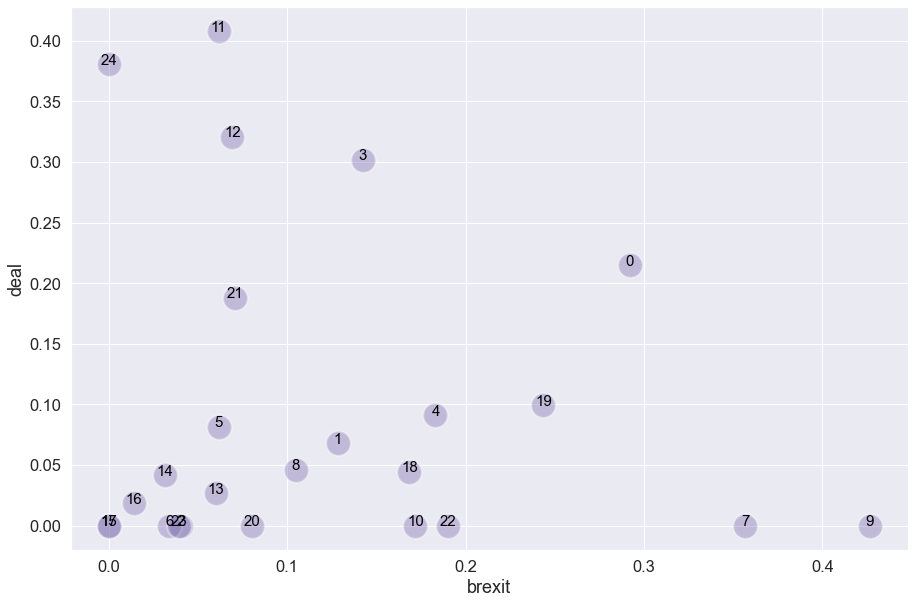

In [174]:
# Create figure and set figure size
sns.set_context("notebook", font_scale=1.5)
plt.figure(figsize = (15,10))

# Create scatterplot — alpha controls the transparency and s controls the size of markers
fig = sns.scatterplot(data=tf_idf_df, x='brexit', y='deal', alpha=0.4, s=600, color = 'm')
# fig.set_xlabel("Brexit")
# fig.set_ylabel("Deal")

# Add label for each point
for line in range(0,tf_idf_df.shape[0]):
    fig.text(tf_idf_df.brexit[line], tf_idf_df.deal[line], tf_idf_df.index[line], 
             horizontalalignment='center', size='small', color='black', weight='light') # possibly add fontsize=15

In the figure above, dots are documents and dot labels indicate the ID of the document in the index column in the DataFrame—if you have more interpretable labels, you could easily plot them instead of the index. You can identify from the figure, for example, the documents that focus on the word 'deal', including documents 11, 24, 12, 3, 0, and 21. While all documents are related to Brexit, the TF-IDF score for brexit is low for some documents due to the fact that the word brexit was not mentioned in the text of those document.

### Cluster the 25 docuemtns about Brexit using scikit-learn's implementations of [Principal Component Analysis (PCA)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and [K-means clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

#### Principal Component Analysis (PCA)
The above analysis visualises documents with respect to only two tokens/features/vectors. To visualise documents with respect to all tokens, we will apply a useful technique for dimensionality reduction called Principal Component Analysis (PCA). PCA takes multidimensional data and projects each data point in the sample into few components (we will use the first two components) that preserve as much as possible the variance in the data. For more information about PCA and how to implement it in Python, read [here](http://www.textbook.ds100.org/ch/25/pca_dims.html).


In [175]:
# Principal Component Analysis

# Initialise the PCA estimator and keep the first 2 components
pca = PCA(n_components=2)

# Fit the PCA estimator; first convert the sparse matrix to an array using toarray 
pca_components=pca.fit_transform(matrix.toarray())
pca_components

array([[-0.42915519, -0.24026024],
       [-0.36905223, -0.2379418 ],
       [ 0.193108  ,  0.20403933],
       [-0.07422915,  0.03068645],
       [ 0.39249873, -0.21971643],
       [-0.22357238, -0.35009338],
       [ 0.56298666, -0.08676933],
       [-0.01669904, -0.44394412],
       [ 0.13384585,  0.1587959 ],
       [-0.04728461,  0.08816166],
       [-0.26342658, -0.14429162],
       [-0.24987842,  0.31663278],
       [ 0.01724922,  0.43996804],
       [ 0.50883636, -0.05333762],
       [ 0.54343413, -0.01296881],
       [-0.33999715,  0.24685204],
       [ 0.47282472, -0.06954938],
       [-0.28952283, -0.14960373],
       [-0.09463574,  0.12318203],
       [-0.07536453, -0.26365581],
       [-0.2668073 ,  0.14412208],
       [ 0.07500713,  0.51434444],
       [ 0.04188639, -0.2805643 ],
       [ 0.07042451,  0.07814859],
       [-0.27247655,  0.20776322]])

#### K-means clustering
Clustering is an approach that aims to group a set of observations into subgroups or clusters (without any prior information about cluster membership) such that observations assigned to the same cluster are more similar to each other than those in other clusters. We will employ the _k_-means clustering algorithm. 

In [188]:
# Initialise the k-means estimator with 3 clusters
kmeans = KMeans(n_clusters=3)

# Fit the k-means estimator using the two components 
kmeans.fit(pca_components)
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 0, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2,
       1, 2, 2, 2, 0, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1,
       2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1],
      dtype=int32)

In [189]:
# Add the cluster variable as a column in the tf_idf_df variable
tf_idf_df['cluster'] = kmeans.labels_
tf_idf_df

,accord,add,allow,ask,big,billion,brexit,build,business,california,...,website,week,work,world,write,year,category,pca_components_1,pca_components_2,cluster
0,0.065904,0.000000,0.000000,0.000000,0.073009,0.088046,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,-0.066196,-0.003631,1
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,-0.097548,-0.082588,1
2,0.079559,0.171984,0.000000,0.000000,0.088136,0.106290,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.074522,0.177753,0.000000,0.000000,0,-0.000532,-0.063694,1
3,0.040884,0.034369,0.026728,0.026259,0.080517,0.054620,0.0,0.023524,0.024954,0.014896,...,0.006658,0.091802,0.029785,0.060895,0.028260,0.214770,0,-0.187588,-0.463425,1
4,0.028326,0.153084,0.033334,0.032748,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.026533,0.221506,0.035244,0.093982,0,-0.043731,-0.109603,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,0.000000,0.060369,0.000000,0.000000,0.000000,0.000000,0.0,0.072309,0.061363,0.000000,...,0.000000,0.000000,0.000000,0.062394,0.000000,0.000000,1,0.463091,0.084980,0
171,0.000000,0.106149,0.115568,0.000000,0.000000,0.131204,0.0,0.000000,0.107898,0.000000,...,0.000000,0.000000,0.000000,0.109710,0.000000,0.081459,1,0.387182,-0.038194,0
172,0.000000,0.050041,0.000000,0.000000,0.102578,0.061853,0.0,0.000000,0.101732,0.000000,...,0.000000,0.049244,0.043366,0.051720,0.057605,0.192009,0,0.181517,0.050573,1
173,0.129818,0.140315,0.000000,0.000000,0.000000,0.260152,0.0,0.000000,0.071313,0.000000,...,0.000000,0.000000,0.121598,0.000000,0.080761,0.053839,0,0.050477,-0.173059,1


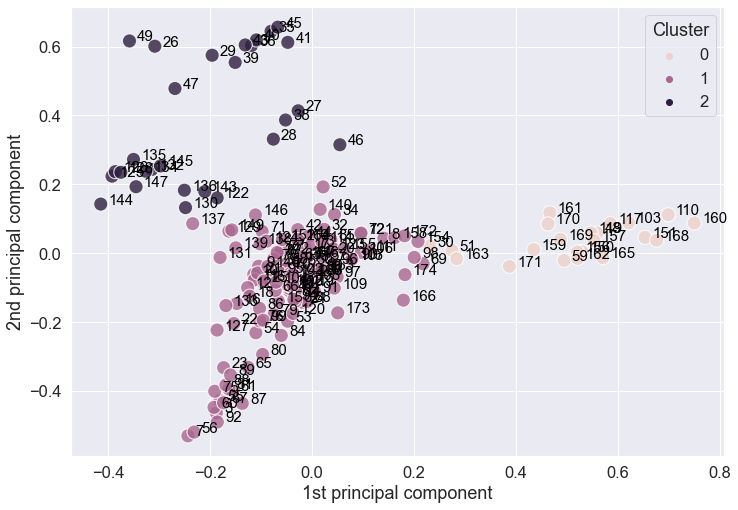

In [190]:
# Assign a document to a category 
tf_idf_df['category'] = kmeans.labels_
tf_idf_df['pca_components_1'] = pca_components[:, 0]
tf_idf_df['pca_components_2'] = pca_components[:, 1]

# Set figure size
sns.set_context("notebook", font_scale=1.5)
plt.figure(figsize = (11.7,8.27))

# Scatterplot with the 1st principal component on the horizontal x axes and 2nd principal component on the vertical y axis
fig = sns.scatterplot(x = pca_components[:, 0], y = pca_components[:, 1], hue=kmeans.labels_, alpha=0.8, s=200)

# This for loop assign country name to each data point iteratively
for line in range(0,tf_idf_df.shape[0]):
     fig.text(pca_components[line,0]+0.015, pca_components[line,1], # where the labels should be positioned
     tf_idf_df.index[line], # add labels to each data point 
     horizontalalignment='left', size='small', color='black', weight='light') # possibly add fontsize=10

# Add labels to the horisontal x axis and vertical y axis
labels = fig.set(xlabel='1st principal component', ylabel='2nd principal component')

# Add title 'Cluster' to the legend and locate it in the upper right of the plot
legend = plt.legend(title='Cluster', loc='upper right')

### Cluster the TF-IDF for the entire corpus using Principal Component Analysis and K-means clustering  

In [191]:
# Compute TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', 
                             min_df = 0.1, 
                             max_df = 0.9, # threshold depends on corpus and question
                             max_features=100) 
matrix = vectorizer.fit_transform(corpus['tokens'])

# DataFrame
tf_idf_df = pd.DataFrame(matrix.toarray(), columns=vectorizer.get_feature_names())
tf_idf_df

,accord,add,allow,ask,big,billion,brexit,build,business,california,...,user,video,want,way,website,week,work,world,write,year
0,0.065904,0.000000,0.000000,0.000000,0.073009,0.088046,0.0,0.000000,0.000000,0.000000,...,0.000000,0.172412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.079559,0.171984,0.000000,0.000000,0.088136,0.106290,0.0,0.000000,0.000000,0.000000,...,0.107447,0.104068,0.000000,0.000000,0.000000,0.000000,0.074522,0.177753,0.000000,0.000000
3,0.040884,0.034369,0.026728,0.026259,0.080517,0.054620,0.0,0.023524,0.024954,0.014896,...,0.000000,0.005942,0.101466,0.014157,0.006658,0.091802,0.029785,0.060895,0.028260,0.214770
4,0.028326,0.153084,0.033334,0.032748,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.030129,0.088280,0.000000,0.000000,0.026533,0.221506,0.035244,0.093982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,0.000000,0.060369,0.000000,0.000000,0.000000,0.000000,0.0,0.072309,0.061363,0.000000,...,0.075431,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062394,0.000000,0.000000
171,0.000000,0.106149,0.115568,0.000000,0.000000,0.131204,0.0,0.000000,0.107898,0.000000,...,0.000000,0.000000,0.104458,0.000000,0.000000,0.000000,0.000000,0.109710,0.000000,0.081459
172,0.000000,0.050041,0.000000,0.000000,0.102578,0.061853,0.0,0.000000,0.101732,0.000000,...,0.062527,0.000000,0.000000,0.096193,0.000000,0.049244,0.043366,0.051720,0.057605,0.192009
173,0.129818,0.140315,0.000000,0.000000,0.000000,0.260152,0.0,0.000000,0.071313,0.000000,...,0.087662,0.000000,0.000000,0.000000,0.000000,0.000000,0.121598,0.000000,0.080761,0.053839


In [192]:
# Repeat the Principal Component Analysis workflow

# Initialise the PCA estimator with 2 components
pca = PCA(n_components=2)

# Fit the PCA estimator; first convert the sparse matrix to an array using toarray 
pca_components=pca.fit_transform(matrix.toarray())
pca_components

array([[-6.61963931e-02, -3.63090245e-03],
       [-9.75482173e-02, -8.25877564e-02],
       [-5.31959149e-04, -6.36937564e-02],
       [-1.87588293e-01, -4.63424640e-01],
       [-4.37310299e-02, -1.09602644e-01],
       [-2.38724981e-02, -3.38947938e-02],
       [-8.43288831e-02, -7.81550153e-02],
       [-2.43443458e-01, -5.30210287e-01],
       [ 1.40954873e-01,  4.36023283e-02],
       [-1.04788976e-01, -3.77348265e-02],
       [-1.14207638e-01, -6.11907631e-02],
       [-1.13103527e-01, -7.74184456e-02],
       [-1.26320310e-01, -9.97415669e-02],
       [-4.29155833e-02, -1.03284384e-01],
       [-2.91220846e-02, -1.24229592e-01],
       [-6.60969878e-02, -1.39188653e-01],
       [-1.47555607e-01, -1.46088939e-01],
       [-1.31295614e-02,  1.41393165e-02],
       [-1.22373936e-01, -1.24769807e-01],
       [-3.74380184e-03, -9.28317802e-02],
       [ 3.72438353e-02,  1.85642470e-03],
       [-1.06741595e-01, -5.73004612e-02],
       [-1.53413113e-01, -2.04184752e-01],
       [-1.

### How do we know how many clusters to form? 
We can learn the optimal number of clusters for our data authomatically. We run the k-means algorithm with various values of _k_ and plot each value of _k_ against the sum of squared distances between each data point (document) and its cluster centre.

In [193]:
Sum_of_squared_errors = [] # Initialise a list

K = range(1,31)
for k in K:
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(pca_components)
  Sum_of_squared_errors.append(kmeans.inertia_)   

Sum_of_squared_errors

[18.308488821936585,
 11.624112439442396,
 5.794816563255838,
 3.4966022033514905,
 2.468468010252049,
 1.7696972964116677,
 1.4183086562831857,
 1.1813336088848796,
 1.032941191330381,
 0.9175710697138117,
 0.804568087853576,
 0.7160727881588413,
 0.6221068545734516,
 0.5708646572261629,
 0.5265467642032732,
 0.515869780872843,
 0.4566021524727215,
 0.42235850143709175,
 0.39568341429545184,
 0.37287072022959933,
 0.35014962031289404,
 0.33619264945798155,
 0.3178355108042991,
 0.296030171711711,
 0.2772329988048222,
 0.27239471024818795,
 0.24983306923874696,
 0.23405490822860295,
 0.22762481282284003,
 0.22144831614440338]

#### Plot k against the sum of squared distances
We perform multiple runs of the k-means clustering algorithm, and the plot below shows how the sum of squared distances varies with values of _k_ between 1 and 30. 

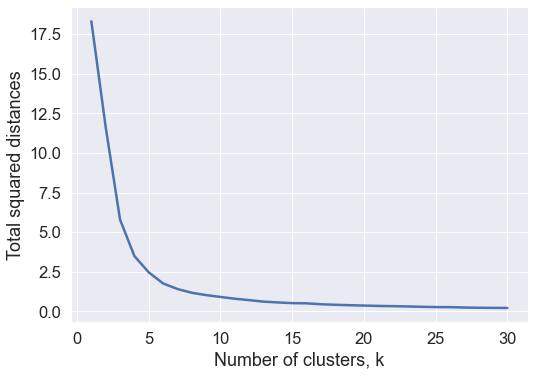

In [194]:
# Plot appearance and size
sns.set(rc={'figure.figsize':(8.2,5.8)})
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

# Generate the plot
fig = sns.lineplot(x= K, y = Sum_of_squared_errors)    

# Add x and y labels
labels = fig.set(xlabel='Number of clusters, k', ylabel='Total squared distances')

The total squared distances decreases slowly after _k_ in the range 4 to 6. We run our k-means algorithm on the entire dataset with _k_ = 4.

In [197]:
# Initialise the k-means estimator with 3 clusters
kmeans = KMeans(n_clusters=4)

# Fit the k-means estimator using the two components 
kmeans.fit(pca_components)
kmeans.labels_

array([1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       3, 3, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 2, 0, 1, 2, 1, 1, 3, 3, 3, 1, 1, 2, 3, 3, 1, 1, 1, 3,
       1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 3, 1, 1, 3, 1, 1, 3,
       3, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 0, 1, 1, 0, 0, 3, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 2, 2, 1, 1,
       1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1],
      dtype=int32)

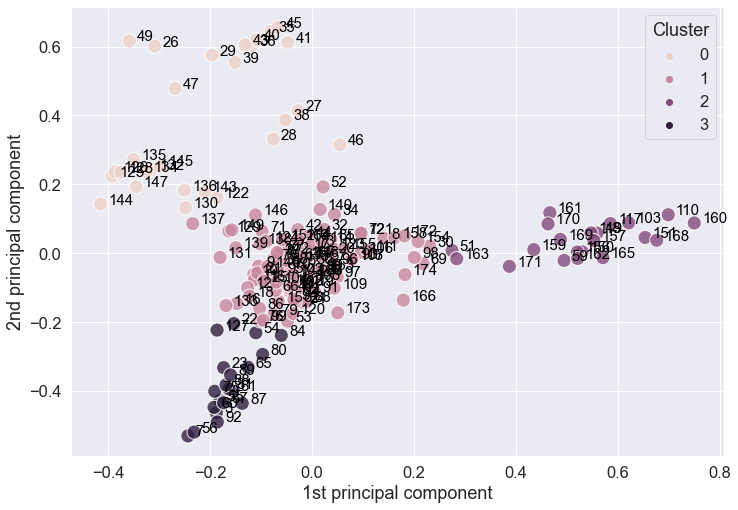

In [198]:
# Assign a document to a category 
tf_idf_df['category'] = kmeans.labels_
tf_idf_df['pca_components_1'] = pca_components[:, 0]
tf_idf_df['pca_components_2'] = pca_components[:, 1]

# Set figure size
sns.set_context("notebook", font_scale=1.5)
plt.figure(figsize = (11.7,8.27))

# Scatterplot with the 1st principal component on the horizontal x axes and 2nd principal component on the vertical y axis
fig = sns.scatterplot(x = pca_components[:, 0], y = pca_components[:, 1], hue=kmeans.labels_, alpha=0.8, s=200)

# This for loop assign country name to each data point iteratively
for line in range(0,tf_idf_df.shape[0]):
     fig.text(pca_components[line,0]+0.015, pca_components[line,1], # where the labels should be positioned
     tf_idf_df.index[line], # add labels to each data point 
     horizontalalignment='left', size='small', color='black', weight='light') # possibly add fontsize=10

# Add labels to the horisontal x axis and vertical y axis
labels = fig.set(xlabel='1st principal component', ylabel='2nd principal component')

# Add title 'Cluster' to the legend and locate it in the upper right of the plot
legend = plt.legend(title='Cluster', loc='upper right')

In [ ]:
### Use the TF-IDF matrix to compute the cosine similarity 

In [219]:
# Import cosine_similarity
from sklearn.metrics.pairwise import cosine_similarity # Generate cosine similarity matrix
cosine_sim = cosine_similarity(matrix, matrix)  
cosine_sim

array([[1.        , 0.29052954, 0.22393939, ..., 0.15138767, 0.21431428,
        0.17475166],
       [0.29052954, 1.        , 0.14084473, ..., 0.12552858, 0.18381036,
        0.01506135],
       [0.22393939, 0.14084473, 1.        , ..., 0.36031953, 0.35822685,
        0.1862068 ],
       ...,
       [0.15138767, 0.12552858, 0.36031953, ..., 1.        , 0.49885136,
        0.23204223],
       [0.21431428, 0.18381036, 0.35822685, ..., 0.49885136, 1.        ,
        0.31518431],
       [0.17475166, 0.01506135, 0.1862068 , ..., 0.23204223, 0.31518431,
        1.        ]])

In [220]:
# Convert to a DataFrame
print(len(cosine_sim))
cosine_sim_list  = cosine_sim.tolist()
cosine_sim_df = pd.DataFrame.from_records(cosine_sim_list)

175


<AxesSubplot:>

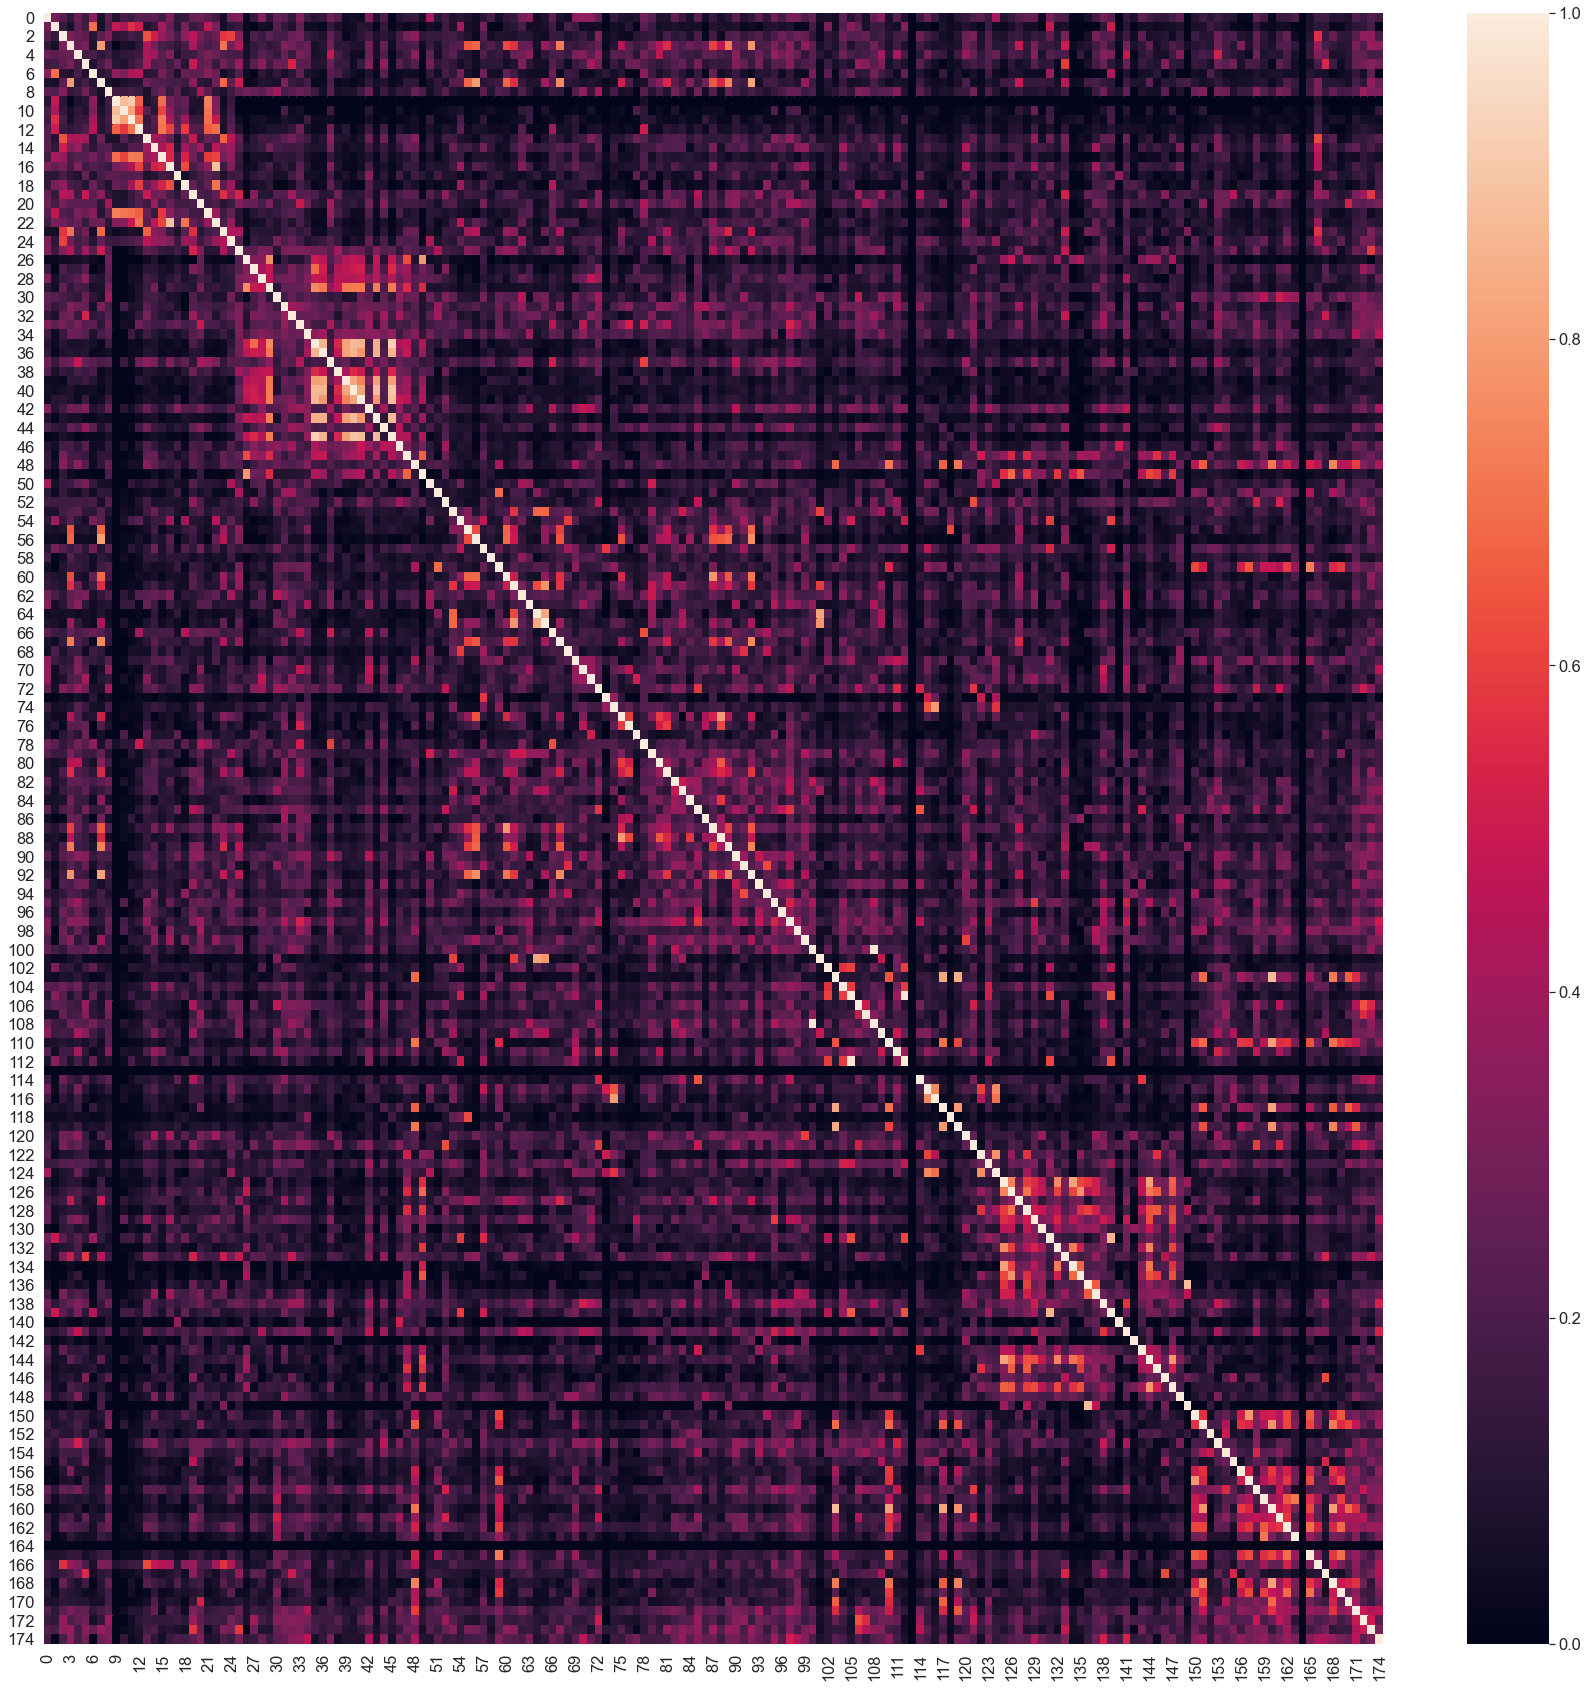

In [221]:
plt.figure(figsize = (30,30))
sns.heatmap(cosine_sim_df)

## Acknowledgements

1. [Converting Text to Features,](https://learning.oreilly.com/library/view/natural-language-processing/9781484242674/html/475440_1_En_3_Chapter.xhtml#) in _Natural Language Processing Recipes_. Akshay Kulkarni & Adarsha Shivananda. 2019.
2. [Sklearn's module on feature extraction](https://scikit-learn.org/stable/modules/feature_extraction.html).
3. [Vector Semantics and Embeddings,](https://web.stanford.edu/~jurafsky/slp3/6.pdf) in _Speech and Language Processing_. Daniel Jurafsky & James H. Martin. Draft of December 30, 2020.
4. [K-Means Clustering with scikit-learn.](http://jonathansoma.com/lede/algorithms-2017/classes/clustering/k-means-clustering-with-scikit-learn/)
5. [Pandas for Everyone.](https://www.pearson.com/us/higher-education/program/Chen-Pandas-for-Everyone-Python-Data-Analysis/PGM335102.html). Daniel Chen. 2018. 